In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
sessions = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
from datetime import datetime, timedelta
from sqlalchemy import func, inspect

#Get column names and types for the "measurement" table
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
recent_date = sessions.query(Measurement).order_by(Measurement.date.desc()).first()
recent_date_str = recent_date.date
recent_date_str

'2017-08-23'

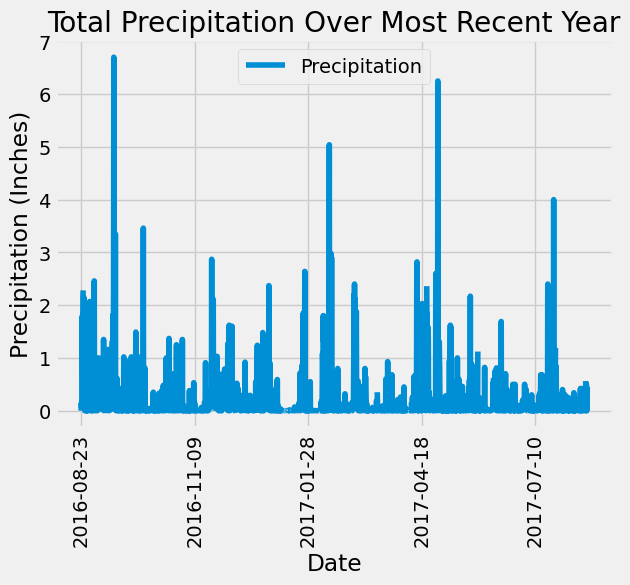

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date_dt = dt.datetime.strptime(recent_date_str, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
year_ago_dt = recent_date_dt - dt.timedelta(days=365)
year_ago_str = str(year_ago_dt)
year_ago_str

# Perform a query to retrieve the data and precipitation scores
recent_year = sessions.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >= year_ago_str).\
    filter(Measurement.date <= recent_date_str).\
    order_by(Measurement.date)
recent_year_sql = str(recent_year)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.read_sql(recent_year_sql, engine, params=(year_ago_str, recent_date_str))
precipitation_df = precipitation_df.rename(columns={"measurement_prcp": "Precipitation", 
                                                    "measurement_date": "Date"})
# Sort the dataframe by date
precipitation_df = precipitation_df.set_index(["Date"])

# Use Pandas Plotting with Matplotlib to plot the data.
precipitation_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title("Total Precipitation Over Most Recent Year")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()
summary_statistics

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
inspector = inspect(engine)
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to calculate the total number of stations in the dataset
sessions.query(func.count(Station.station)).all()

[(9,)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query to find the most active station ID
# List the stations and their counts in descending order.
most_active_station_id = sessions.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

# Calculate lowest, highest, and average temperature for the most active station
temperature_stats = sessions.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()

# Print the results
print("Most Active Station ID:", most_active_station_id)
print("Lowest Temperature:", temperature_stats[0][0])
print("Highest Temperature:", temperature_stats[0][1])
print("Average Temperature:", temperature_stats[0][2])

Most Active Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


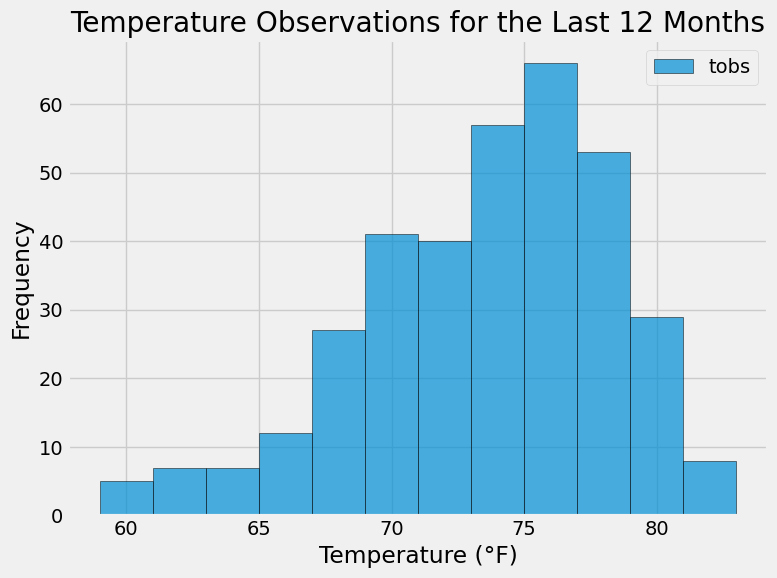

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = sessions.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= year_ago_str).\
    filter(Measurement.date <= recent_date_str).all()

# Convert the query results to a list
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, edgecolor='black', alpha=0.7)
plt.title('Temperature Observations for the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.tight_layout()
plt.show()

# Close Session

In [17]:
# Close Session
sessions.close()